# Segmenting and Clustering Neighborhoods in Toronto

### Install necessary libraries

In [223]:
!pip install requests bs4 pandas lxml geocoder scikit-learn matplotlib

     |████████████████████████████████| 11.5 MB 4.1 MB/s 
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
     |████████████████████████████████| 1.2 MB 19.2 MB/s 
     |████████████████████████████████| 2.2 MB 35.6 MB/s 


### Import necessary libraries

In [228]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import geocoder
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors


Get a request for the target table, and get it into dataframe format

In [3]:
req = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(req.content, "lxml")
table = soup.find_all("table")[0]
df = pd.read_html(str(table))[0]
df

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


### Filter all the rows where the borough is "Not assigned"

In [4]:
df_f = df.loc[~df.Borough.str.contains("Not assigned") ]
df_f.reset_index(drop=True, inplace=True)
df_f


,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


### Verify if the postal codes are unique

In [5]:
postal_codes = df_f["Postal Code"].unique()
print(f"There are {len(postal_codes)} unique postal codes for {len(df_f)} rows.")
if len(postal_codes) == len(df_f):
    print("There are no duplicate postal codes.")    

There are 103 unique postal codes for 103 rows.
There are no duplicate postal codes.


In [6]:
df_f.loc[df_f["Postal Code"].str.contains(postal_codes[3])] 

,Postal Code,Borough,Neighbourhood
3,M6A,North York,"Lawrence Manor, Lawrence Heights"


In [7]:
print(len(df_f), len(postal_codes))

103 103


### Check for unassigned Burroughs

In [8]:
df_f.loc[df_f["Neighbourhood"].str.contains("Not assigned")]

,Postal Code,Borough,Neighbourhood


### Try to get data from geocoder 

In [15]:
postal_dict = {}

for postal_code in postal_codes:

    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    count = 0
    maxtries=15
    while(lat_lng_coords is None):
        count+=1
        g = geocoder.google(f'{postal_code}, Toronto, Ontario')
        lat_lng_coords = g.latlng
        print(".")
        if count > maxtries:
            break
    if count > maxtries:
        break 
    print(postal_code, lat_lng_coords)
    postal_dict[postal_code] = lat_lng_coords

postal_dict


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


{}

In [16]:
g

<[REQUEST_DENIED] Google - Geocode [empty]>

Didn't work, better try the csv file

In [17]:
new_df = pd.read_csv("Geospatial_Coordinates.csv")
new_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [18]:
lats = []
longs = []

for idx,postal_code in df_f["Postal Code"].iteritems():
    row2 = new_df.loc[new_df["Postal Code"]==postal_code]
    lats.append(row2.Latitude.values[0])
    longs.append(row2.Longitude.values[0])

df_f["Latitude"] = lats
df_f["Longitude"] = longs
df_f.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# Visualize all the locations

In [19]:
!pip install folium
import folium

     |████████████████████████████████| 94 kB 3.1 MB/s 


In [20]:
toronto_central_lat = df_f.Latitude.mean()
toronto_central_long = df_f.Longitude.mean()

map_toronto = folium.Map(location=[toronto_central_lat, toronto_central_long], zoom_start=12)
for idx,row in df_f.iterrows():
    labeltext = f"{row.Neighbourhood}, {row.Borough}"
    label = folium.Popup(labeltext, parse_html=True)
    # print(row.Latitude, row.Longitude, label)
    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        color='blue',
        fill=True,
        radius=3,
        popup=label,
        parse_html=False
    ).add_to(map_toronto)

map_toronto


In [21]:
### Initialize foursquare credentials


In [22]:
CLIENT_ID = '0RZJ4G2A4EJMGUILKEX50CYWEET3GSSUGPUQNAZOP4ROKITK' # your Foursquare ID
CLIENT_SECRET = 'EMRO3ISWWVTWTZ3AEURZCCYXIJMWHQNFLPNNSN5435FSLQTN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [132]:
def get_search_url(lat, lon, rad):
    url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lon}&radius={rad}&limit={LIMIT}'
    return url

def get_category(row):
    if row["venue.categories"][0]:
        return row["venue.categories"][0]["name"]

def get_nearby_venues(url):
    result = requests.get(url).json()
    venues = result["response"]["groups"][0]["items"]
    venues_df = pd.json_normalize(venues)
    if len(venues_df) == 0:
        print(result)
        return pd.DataFrame({})
    relevant_columns = ["venue.name", "venue.categories", "venue.location.lat", "venue.location.lng"]
    # print(venues_df.head())
    venues_df = venues_df.loc[:, relevant_columns]
    venues_df["venue.categories"] = venues_df.apply(get_category, axis=1)
    venues_df.columns = [col.split(".")[-1] for col in venues_df.columns]
    return venues_df

In [133]:
radius=500

venues_list = []


for idx, row in df_f.iterrows():
    search_url = get_search_url(row.Latitude, row.Longitude, radius)
    venues = get_nearby_venues(search_url)
    if not venues.empty:
        venues["Neighbourhood"] = row.Neighbourhood
        venues_list.append(venues)

{'meta': {'code': 200, 'requestId': '601af000f46d4b3a949604c8'}, 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."}, 'headerLocation': 'Edenbridge - Humber Valley', 'headerFullLocation': 'Edenbridge - Humber Valley, Toronto', 'headerLocationGranularity': 'neighborhood', 'totalResults': 0, 'suggestedBounds': {'ne': {'lat': 43.672355604500005, 'lng': -79.52603299418392}, 'sw': {'lat': 43.6633555955, 'lng': -79.53845180581608}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': []}]}}
{'meta': {'code': 200, 'requestId': '601af0111cd156130c39c0b0'}, 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."}, 'headerLocation': 'St. Andrew - Windfields', 'headerFullLocation': 'St. Andrew - Windfields, Toronto', 'headerLocationGranularity': 'neighborhood', 'totalResults': 0, 'sugg

In [165]:
all_venues = pd.concat(venues_list, ignore_index=True)
print(len(all_venues))
all_venues.head()

2099


,name,categories,lat,lng,Neighbourhood
0,Brookbanks Park,Park,43.751976,-79.332140,Parkwoods
1,Brookbanks Pool,Pool,43.751389,-79.332184,Parkwoods
2,Variety Store,Food & Drink Shop,43.751974,-79.333114,Parkwoods
3,Victoria Village Arena,Hockey Arena,43.723481,-79.315635,Victoria Village
4,Portugril,Portuguese Restaurant,43.725819,-79.312785,Victoria Village


In [166]:
all_venues.groupby("Neighbourhood").count()

,name,categories,lat,lng
Neighbourhood,,,,
Agincourt,4,4,4,4
"Alderwood, Long Branch",7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22
Bayview Village,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24
...,...,...,...,...
"Willowdale, Willowdale East",34,34,34,34
"Willowdale, Willowdale West",5,5,5,5
Woburn,4,4,4,4


In [167]:
all_venues.groupby("categories").count()

,name,lat,lng,Neighbourhood
categories,,,,
Accessories Store,1,1,1,1
Adult Boutique,1,1,1,1
Airport,2,2,2,2
Airport Food Court,1,1,1,1
Airport Gate,1,1,1,1
...,...,...,...,...
Wine Bar,9,9,9,9
Wine Shop,2,2,2,2
Wings Joint,1,1,1,1


In [250]:
onehot = pd.get_dummies(all_venues.categories, prefix="", prefix_sep="")
onehot["Neighbourhood"] = all_venues.Neighbourhood

fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [251]:
cat_density = onehot.groupby("Neighbourhood").mean().reset_index()

In [252]:
cat_density

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.029412,0.0,0.0,0.0,0.0,0.0,0.0
92,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
93,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
94,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [253]:
num_top_venues = 5

for hood in cat_density['Neighbourhood']:
    print("----"+hood+"----")
    temp = cat_density[cat_density['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

    Coffee Shop  0.09
1        Cocktail Bar  0.05
2         Cheese Shop  0.04
3  Seafood Restaurant  0.04
4            Beer Bar  0.04


----Birch Cliff, Cliffside West----
                   venue  freq
0        College Stadium  0.25
1           Skating Rink  0.25
2  General Entertainment  0.25
3                   Café  0.25
4            Men's Store  0.00


----Brockton, Parkdale Village, Exhibition Place----
               venue  freq
0               Café  0.14
1     Breakfast Spot  0.09
2        Coffee Shop  0.09
3  Convenience Store  0.05
4          Nightclub  0.05


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
           venue  freq
0            Spa  0.07
1  Auto Workshop  0.07
2     Comic Shop  0.07
3    Pizza Place  0.07
4     Restaurant  0.07


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.19
1    Airport Lounge  0.

In [254]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = cat_density['Neighbourhood']

for ind in np.arange(cat_density.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cat_density.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Clothing Store,Lounge,Breakfast Spot,Latin American Restaurant,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop
1,"Alderwood, Long Branch",Pizza Place,Skating Rink,Coffee Shop,Pub,Pharmacy,Gym,Health Food Store,Moving Target,Men's Store,Health & Beauty Service
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Mobile Phone Shop,Sushi Restaurant,Fried Chicken Joint,Supermarket,Bridal Shop,Shopping Mall,Middle Eastern Restaurant,Health Food Store
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Accessories Store,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Juice Bar,Italian Restaurant,Coffee Shop,Pub,Sushi Restaurant,Thai Restaurant,Café,Indian Restaurant,Liquor Store


# Run K-means to cluster the neighbourhoods

In [255]:
# set number of clusters
kclusters = 5

cat_density_clustering = cat_density.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cat_density_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [256]:
neighborhoods_venues_sorted.iloc[0:10,:]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Clothing Store,Lounge,Breakfast Spot,Latin American Restaurant,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop
1,"Alderwood, Long Branch",Pizza Place,Skating Rink,Coffee Shop,Pub,Pharmacy,Gym,Health Food Store,Moving Target,Men's Store,Health & Beauty Service
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Mobile Phone Shop,Sushi Restaurant,Fried Chicken Joint,Supermarket,Bridal Shop,Shopping Mall,Middle Eastern Restaurant,Health Food Store
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Accessories Store,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Juice Bar,Italian Restaurant,Coffee Shop,Pub,Sushi Restaurant,Thai Restaurant,Café,Indian Restaurant,Liquor Store
5,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Seafood Restaurant,Beer Bar,Bakery,Restaurant,Farmers Market,Park,Comfort Food Restaurant
6,"Birch Cliff, Cliffside West",College Stadium,Skating Rink,General Entertainment,Café,Men's Store,Metro Station,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater
7,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Convenience Store,Nightclub,Burrito Place,Stadium,Furniture / Home Store,Bar,Climbing Gym
8,"Business reply mail Processing Centre, South C...",Spa,Auto Workshop,Comic Shop,Pizza Place,Restaurant,Burrito Place,Skate Park,Farmers Market,Fast Food Restaurant,Brewery
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Plane,Harbor / Marina,Boat or Ferry,Sculpture Garden,Rental Car Location,Coffee Shop,Airport


In [257]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_merged = df_f

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
df_merged = df_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

df_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Food & Drink Shop,Park,Pool,Accessories Store,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Pizza Place,Coffee Shop,Hockey Arena,Portuguese Restaurant,Intersection,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Men's Store,Mediterranean Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Restaurant,Electronics Store,Event Space
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Furniture / Home Store,Accessories Store,Event Space,Boutique,Arts & Crafts Store,Miscellaneous Shop,Coffee Shop,Vietnamese Restaurant,Middle Eastern Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Café,Bar,Beer Bar,Fried Chicken Joint,Smoothie Shop,Mexican Restaurant,Burrito Place


In [258]:
# create map
map_clusters = folium.Map(location=[toronto_central_lat, toronto_central_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = matplotlib.cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighbourhood'], df_merged['Cluster Labels']):
    if not np.isnan(cluster):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [356]:
cluster0 = df_merged.loc[df_merged['Cluster Labels'] == 0, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]].reset_index()
cluster0

,index,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,North York,0.0,Food & Drink Shop,Park,Pool,Accessories Store,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant
1,21,York,0.0,Park,Women's Store,Bar,Accessories Store,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant
2,35,East York,0.0,Park,Convenience Store,Intersection,Accessories Store,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop
3,52,North York,0.0,Park,Accessories Store,Mexican Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Metro Station
4,85,Scarborough,0.0,Intersection,Playground,Park,Middle Eastern Restaurant,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
5,91,Downtown Toronto,0.0,Park,Playground,Trail,Accessories Store,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant


In [367]:
cat_density2 = cat_density.copy()
cat_density2.insert(0, 'Cluster Labels', kmeans.labels_)
cat_density2

,Cluster Labels,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,"Willowdale, Willowdale East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.029412,0.0,0.0,0.0,0.0,0.0,0.0
92,1,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
93,1,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
94,1,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [373]:
res_df = pd.DataFrame()
for i in range(kclusters):
    res = cat_density2.loc[cat_density2["Cluster Labels"]==i].mean()
    res_df.insert(0, f'{i}', res)

In [382]:
res_df.corr()

,4,3,2,1,0
4,1.000000,0.953766,0.943071,0.983880,0.021218
3,0.953766,1.000000,0.924135,0.962360,0.033943
2,0.943071,0.924135,1.000000,0.949513,-0.009590
1,0.983880,0.962360,0.949513,1.000000,0.019293
0,0.021218,0.033943,-0.009590,0.019293,1.000000


<AxesSubplot:>

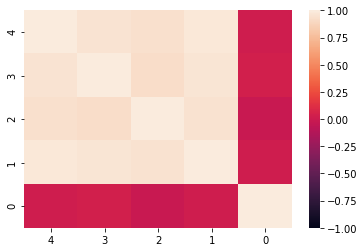

In [380]:

import seaborn as sns
sns.heatmap(res_df.corr(), vmin=-1, vmax=1)

In [385]:
c0 = cluster0.drop(["index","Cluster Labels"], axis=1).set_index("Borough").stack()
pd.DataFrame(c0.value_counts()).T

,Miscellaneous Shop,Park,Mobile Phone Shop,Molecular Gastronomy Restaurant,Modern European Restaurant,Middle Eastern Restaurant,Accessories Store,Monument / Landmark,Mexican Restaurant,Intersection,Moroccan Restaurant,Playground,Women's Store,Convenience Store,Trail,Metro Station,Bar,Food & Drink Shop,Pool
0,6,6,6,6,6,5,5,4,3,2,2,2,1,1,1,1,1,1,1


In [352]:
cluster1 = df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]].reset_index()
c1 = cluster1.drop(["index","Cluster Labels"], axis=1).set_index("Borough").stack()
pd.DataFrame(c1.value_counts()).T

,Coffee Shop,Café,Modern European Restaurant,Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Mobile Phone Shop,Sandwich Place,Pizza Place,Miscellaneous Shop,...,Stadium,Falafel Restaurant,Print Shop,Curling Ice,Comfort Food Restaurant,Martial Arts School,Playground,Noodle House,Garden,Plaza
0,50,33,24,23,22,21,21,20,19,19,...,1,1,1,1,1,1,1,1,1,1


In [353]:
cluster2 = df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]].reset_index()
c2 = cluster2.drop(["index","Cluster Labels"], axis=1).set_index("Borough").stack()
pd.DataFrame(c2.value_counts()).T

,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Accessories Store,Miscellaneous Shop,Mobile Phone Shop,Baseball Field,Middle Eastern Restaurant,Motel,Mexican Restaurant,Fabric Shop,Business Service
0,2,2,2,2,2,2,2,2,1,1,1,1


In [354]:
cluster3 = df_merged.loc[df_merged['Cluster Labels'] == 3, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]].reset_index()
c3 = cluster3.drop(["index","Cluster Labels"], axis=1).set_index("Borough").stack()
pd.DataFrame(c3.value_counts()).T

,Monument / Landmark,Molecular Gastronomy Restaurant,Playground,Mobile Phone Shop,Accessories Store,Miscellaneous Shop,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Metro Station,Restaurant
0,2,2,2,2,2,2,2,2,2,1,1


In [417]:
cluster4 = df_merged.loc[df_merged['Cluster Labels'] == 4, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]].reset_index()
c4 = cluster4.drop(["index","Cluster Labels"], axis=1).set_index("Borough").stack()
pd.DataFrame(c4.value_counts()).T

,Monument / Landmark,Mobile Phone Shop,Bakery,Miscellaneous Shop,Molecular Gastronomy Restaurant,Modern European Restaurant,Accessories Store,Basketball Court,Market,Construction & Landscaping,Moroccan Restaurant,Park,Middle Eastern Restaurant
0,2,2,2,2,2,2,2,1,1,1,1,1,1


In [416]:
# df_merged.loc[df_merged['Cluster Labels'] == 0, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

In [415]:
# df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

In [405]:
res_df.drop("Cluster Labels", inplace=True)

In [418]:
res_df.sort_values("0", ascending=False).head(10)
# Open spaces

,4,3,2,1,0
Park,0.125,0.00,0.0,0.025621,0.527778
Intersection,0.000,0.00,0.0,0.018968,0.097222
Playground,0.000,0.75,0.0,0.003241,0.097222
Pool,0.000,0.00,0.0,0.007049,0.055556
Food & Drink Shop,0.000,0.00,0.0,0.002302,0.055556
Trail,0.000,0.00,0.0,0.009212,0.041667
Bar,0.000,0.00,0.0,0.016710,0.041667
Convenience Store,0.000,0.00,0.0,0.018997,0.041667
Women's Store,0.000,0.00,0.0,0.000000,0.041667
Men's Store,0.000,0.00,0.0,0.001058,0.000000


In [419]:
res_df.sort_values("1", ascending=False).head(10)
# Coffee shops and Restaurants

,4,3,2,1,0
Coffee Shop,0.000,0.00,0.0,0.066003,0.000000
Pizza Place,0.000,0.00,0.0,0.038111,0.000000
Café,0.000,0.00,0.0,0.031338,0.000000
Fast Food Restaurant,0.000,0.00,0.0,0.029440,0.000000
Sandwich Place,0.000,0.00,0.0,0.026228,0.000000
Park,0.125,0.00,0.0,0.025621,0.527778
Bakery,0.625,0.00,0.0,0.019782,0.000000
Restaurant,0.000,0.25,0.0,0.019568,0.000000
Pharmacy,0.000,0.00,0.0,0.019529,0.000000
Convenience Store,0.000,0.00,0.0,0.018997,0.041667


In [420]:
res_df.sort_values("2", ascending=False).head(10)
# Baseball fields

,4,3,2,1,0
Baseball Field,0.0,0.0,0.50,0.001036,0.0
Business Service,0.0,0.0,0.25,0.004019,0.0
Fabric Shop,0.0,0.0,0.25,0.000000,0.0
Accessories Store,0.0,0.0,0.00,0.000992,0.0
Miscellaneous Shop,0.0,0.0,0.00,0.001587,0.0
Monument / Landmark,0.0,0.0,0.00,0.000357,0.0
Molecular Gastronomy Restaurant,0.0,0.0,0.00,0.000124,0.0
Modern European Restaurant,0.0,0.0,0.00,0.000440,0.0
Mobile Phone Shop,0.0,0.0,0.00,0.003889,0.0
Middle Eastern Restaurant,0.0,0.0,0.00,0.006121,0.0


In [421]:
res_df.sort_values("3", ascending=False).head(10)
# Playground

,4,3,2,1,0
Playground,0.0,0.75,0.0,0.003241,0.097222
Restaurant,0.0,0.25,0.0,0.019568,0.000000
Accessories Store,0.0,0.00,0.0,0.000992,0.000000
Middle Eastern Restaurant,0.0,0.00,0.0,0.006121,0.000000
Monument / Landmark,0.0,0.00,0.0,0.000357,0.000000
Molecular Gastronomy Restaurant,0.0,0.00,0.0,0.000124,0.000000
Modern European Restaurant,0.0,0.00,0.0,0.000440,0.000000
Mobile Phone Shop,0.0,0.00,0.0,0.003889,0.000000
Miscellaneous Shop,0.0,0.00,0.0,0.001587,0.000000
Mexican Restaurant,0.0,0.00,0.0,0.009037,0.000000


In [414]:
res_df.sort_values("4", ascending=False).head(10)
#Bakery

,4,3,2,1,0
Bakery,0.625,0.0,0.0,0.019782,0.000000
Construction & Landscaping,0.125,0.0,0.0,0.006944,0.000000
Park,0.125,0.0,0.0,0.025621,0.527778
Basketball Court,0.125,0.0,0.0,0.000000,0.000000
Accessories Store,0.000,0.0,0.0,0.000992,0.000000


In [ ]:
# Retry again with less clusters